In [17]:
%matplotlib inline
# %matplotlib notebook
import h5py
import rasterio
import rasterio.plot 
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
import pandas as pd
import numpy as np
from rasterio import windows
#usar opencv3 para evitar conflictos con rasterio
import cv2 
import os
import utilidades
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from matplotlib import cm as CM
import matplotlib._color_data as mcd
import datetime

In [2]:
cwd = os.getcwd()
# print(cwd)

In [3]:
# os.chdir('D:/Memoria/Codigo/AraucoNursery/')
url_imagen = "PROYECTOS/CONTEO_SATELITE/imagenes/corte_pequeño_dron.tif"
rotados = "PROYECTOS/CONTEO_SATELITE/puntos_cortados.shp"
corte = "PROYECTOS/CONTEO_SATELITE/corte_pequeño.shp"
url_salida = "train/"+str(datetime.datetime.now().day)+"/"
url_salida_png = url_salida+"/png/"
# url_salida_png_1 = "train/"+str(datetime.datetime.now().day)+"/png_1m/"
url_salida_tiff = url_salida+"/tiff/"
url_salida_shp = url_salida+"/shp/"
archivo_h5_cuentas = url_salida+'/data_cuentas.h5'
archivo_h5_mapa = url_salida+'/data_mapa.h5'

In [4]:
carpetas = [url_salida,url_salida_png,url_salida_tiff,url_salida_shp]
for element in carpetas:
    if not os.path.exists(element):
        os.makedirs(element)

## Carga Archivos

In [5]:
# puntos = gpd.read_file(shp)
puntos = gpd.read_file(rotados)
raster = rasterio.open(url_imagen)

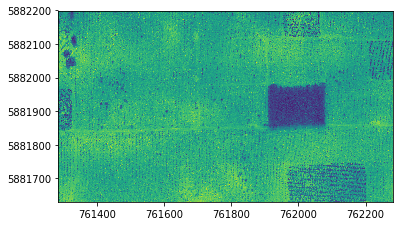

In [8]:
rasterio.plot.show(raster)

## Rotar Puntos

In [15]:
# puntos = gpd.read_file(shp)
# 761.774,565  5.881.886,945 Meters
# puntos = puntos.rotate(-48.01,origin=(761774.565,5881886.945))
# puntos.to_file(driver = 'ESRI Shapefile', filename = "puntos_rotados")
# puntos.plot()

## Cargar Mapa Densidad

In [ ]:
# inicialemnte correr notebook mapa_densidad
mapa_densidad = np.load(url_salida+"/mapa_densidad" + '.npy')
print(np.sum(mapa_densidad),puntos.shape[0])

## Mapa densidad a shapefile

In [20]:
# output_file = 'density_map_final_final.shp'
# utilidades.array_to_shp(mapa_densidad,raster,output_file)

In [29]:
# ruta_1m = "D:/Memoria/Codigo/AraucoNursery/PROYECTOS/cortes/1m.png"
# mapa_densidad=mpimg.imread(ruta_1m)

In [7]:
puntos.shape

(44992, 2)

## Generar mapa Densidad

In [8]:
def get_coordenadas(raster, puntos, url_salida, nombre):
    print(url_salida + nombre + ".csv")
    """
    Dado un raster y un shapefile obtiene las posiciones de los puntos con respecto a x e y de la imagen.
    Genera un csv de la forma x, y (lat, lon)
    :raster: corresponde a una imagen tiff abierta con rasterio
    :puntos: Corresponde a un shapefile abierto en geopandas
    :url_salida: carpeta donde se guardara el csv 
    :nombre: nombre del csv con los puntos
    :return: un array con los puntos de la forma y,x y un csv con los puntos
    """
    coordenadas = []
    pixeles = pd.DataFrame(columns=["x", "y"])
    for index in range(puntos.shape[0]):
        try:
            pl = raster.index(puntos["geometry"][index].bounds[0], puntos["geometry"][index].bounds[1])
            bandera = True
        except:
            print(index)
        if(bandera):
            pixeles.loc[index] = [pl[0], pl[1]]
    pixeles.to_csv(url_salida + nombre + ".csv")

    for element in range(pixeles.shape[0]):
        coordenadas.append((pixeles["y"][element], pixeles["x"][element]))

    return coordenadas, pixeles

In [9]:
coordenadas,pixeles = get_coordenadas(raster,puntos,url_salida,"pixeles")

train/14/pixeles.csv
4924
4925
4926


In [10]:
mapa_densidad = utilidades.get_density_map_gaussian(coordenadas,raster.height,raster.width,sigma=4)

In [13]:
mapa_densidad =mapa_densidad

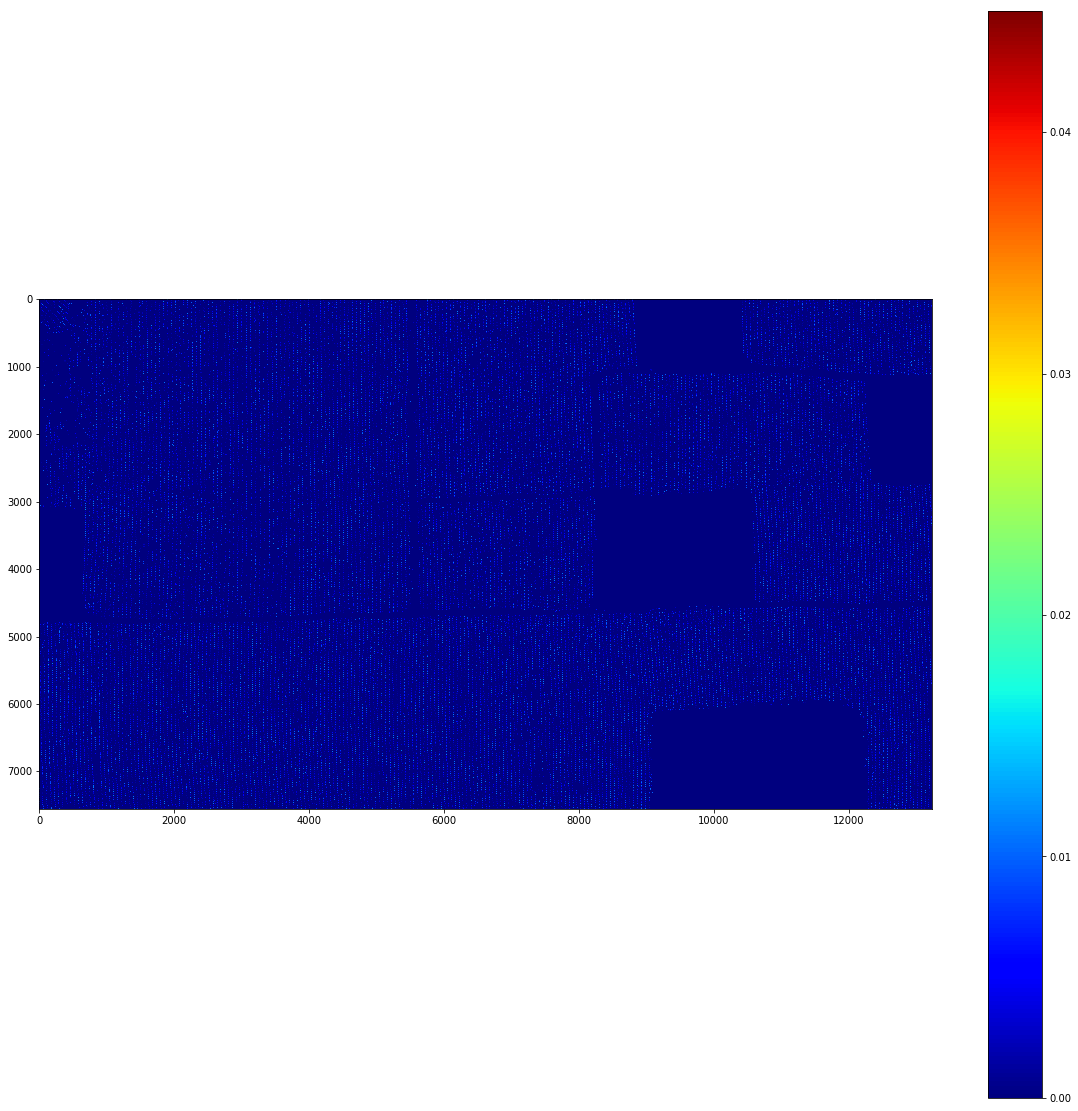

In [69]:
plt.figure(figsize=(20,20))

plt.imshow(mapa_densidad,cmap = CM.jet)
plt.colorbar()
plt.show()

In [14]:
np.sum(mapa_densidad)

44992.047

In [25]:
offsetX = 0
offsetY = 0
width = 100
height = 100
step = 100
nulo = [65535]
#lista de imagenes
lista_imagenes = []
#lista del conteo
lista_etiquetas = []
#lista de los mapas de densidad
lista_mapa = []
contador = 0
colores = list({name for name in mcd.CSS4_COLORS
           if "xkcd:" + name in mcd.XKCD_COLORS})

## Muestra de los cortes a realizar

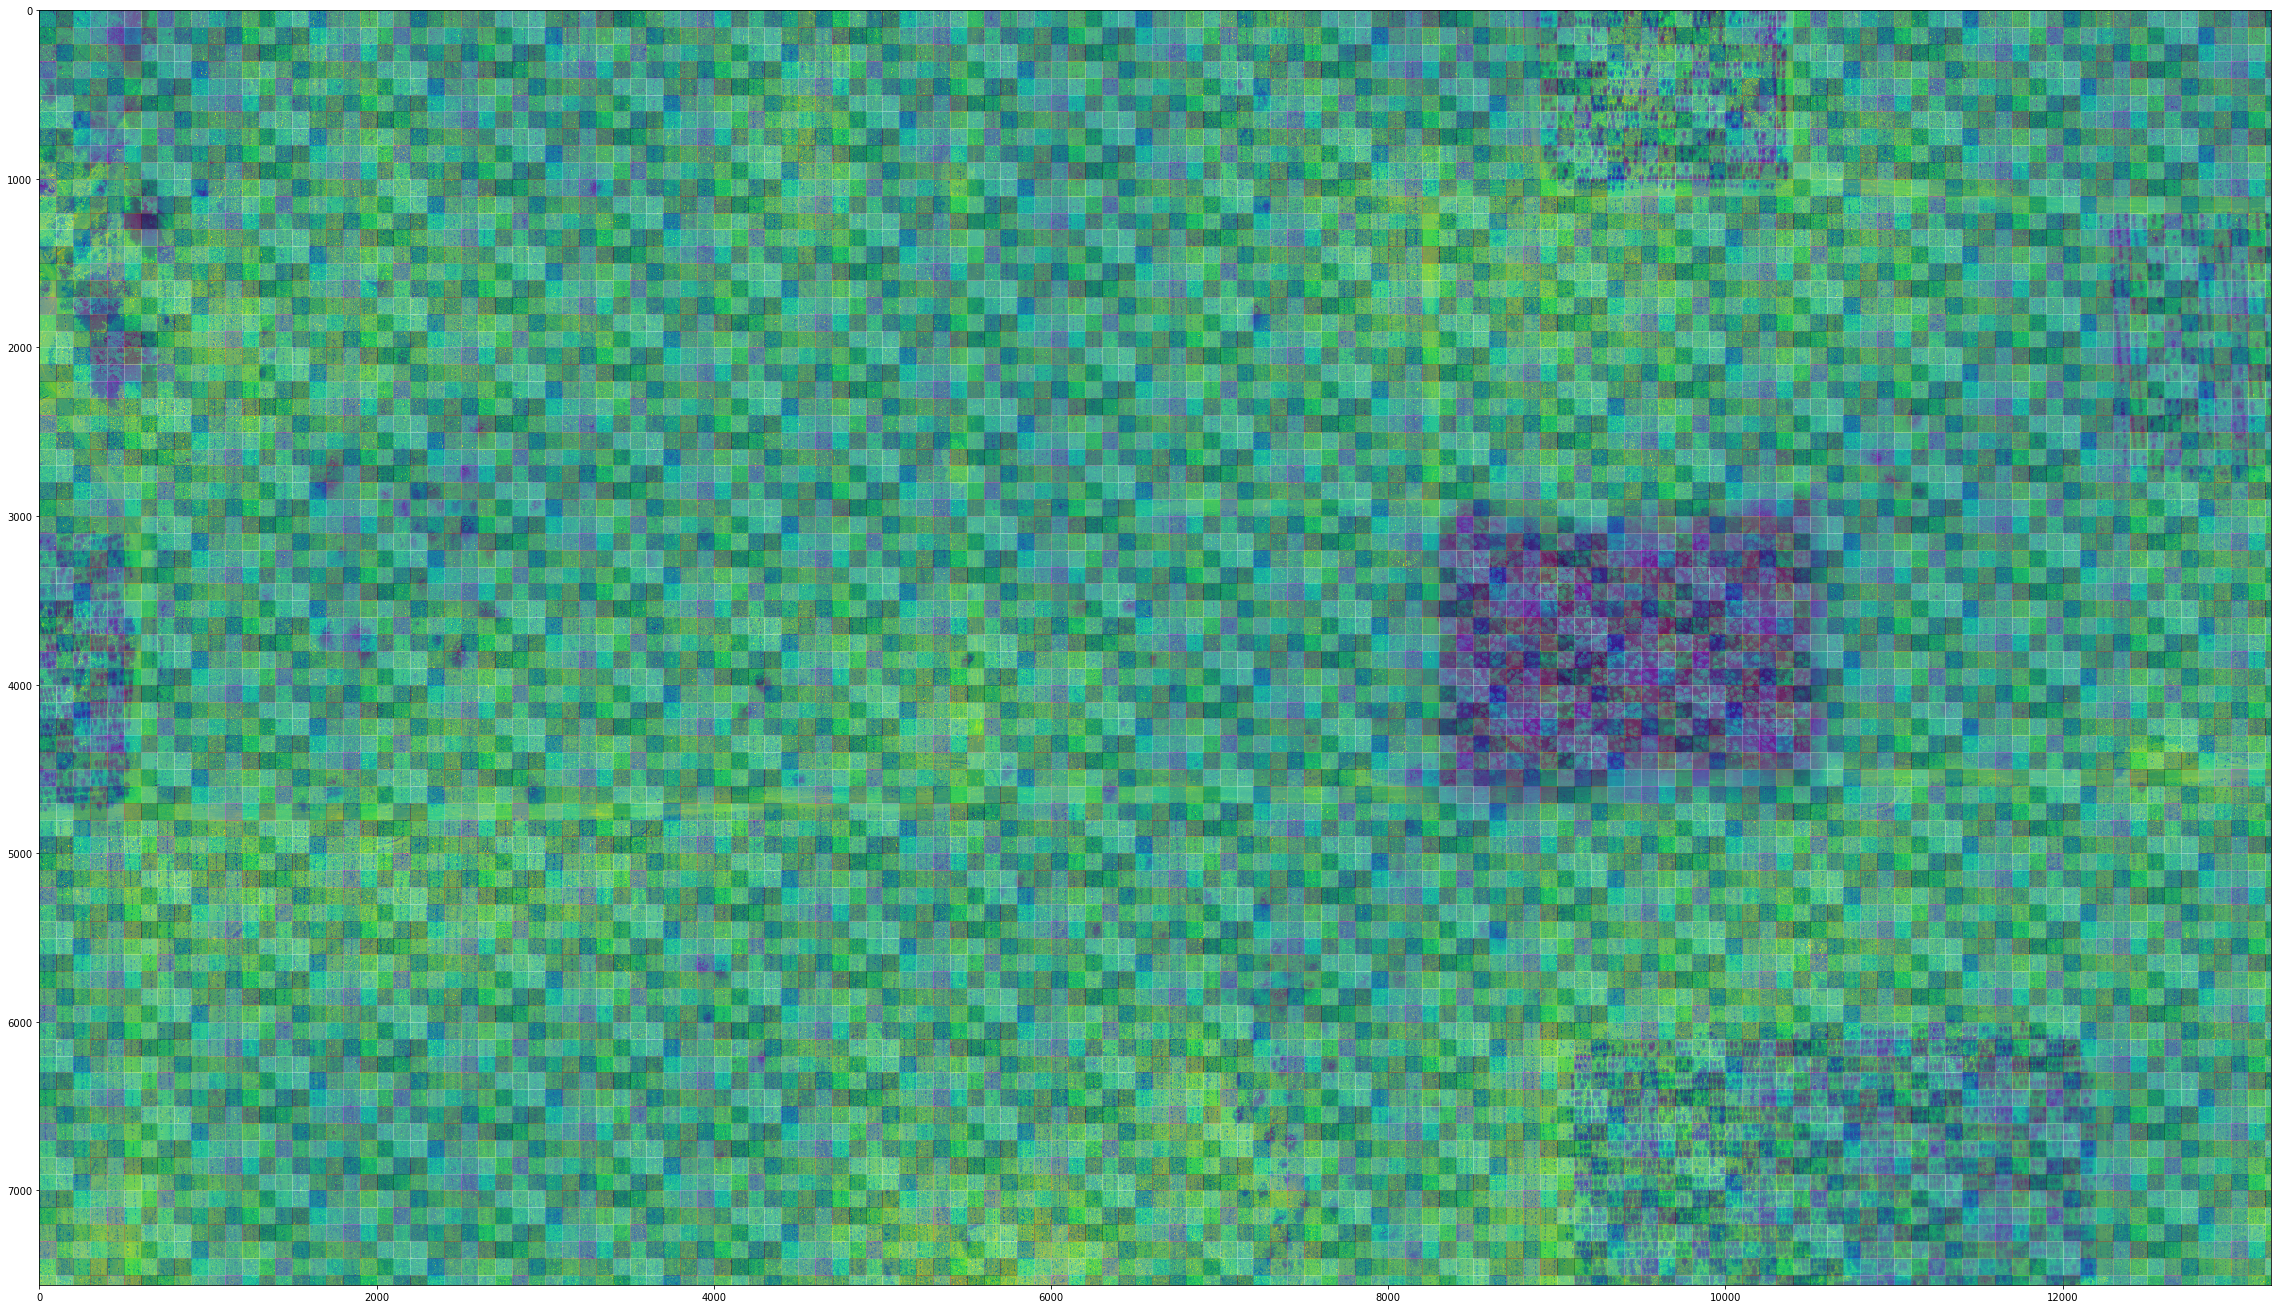

In [26]:
windows_list = []
datos_b1 = raster.read(2)
plt.figure(figsize=(40,40))
plt.imshow(datos_b1)
ax = plt.gca()
while (1):
    # print(offsetY,offsetX,widthX,widthY)
    i_color = (contador)%len(colores)
    offsetX = offsetX + step 
    
     # finalizar si se a recorrido toda la imagen
    if(offsetY >= raster.height and offsetX >= raster.width):
        break
     #cuando llegue al borde en el eje x, debo bajar(sumar en eje y) y debo volver a empezar setear offsetX en 0 y widthX en 100
    elif(offsetX >= raster.width):
        offsetY = offsetY + step
        offsetX = 0
        
    windows_list.append(windows.Window(offsetX,offsetY,width,height))
    ax.add_patch(Rectangle((windows_list[contador].col_off,windows_list[contador].row_off),
                       width=windows_list[contador].width,
                       height=windows_list[contador].height,fill=True,alpha=.2,
                 color=colores[i_color]))
    contador = contador + 1

## Proceso Cortado

In [12]:
%%time
contador = 0
out_meta = raster.meta.copy()
while (1):
        # finalizar si se a recorrido toda la imagen
    if(offsetY >= raster.height and offsetX >= raster.width):
        break
     #cuando llegue al borde en el eje x, debo bajar(sumar en eje y) y debo volver a empezar setear offsetX en 0 y widthX en 100
    elif(offsetX >= raster.width):
        offsetY = offsetY + step
        offsetX = 0
        
    #entregamos los pixeles para obtener las coordenadas
    t = raster.xy(offsetX, offsetY)
    r = raster.xy(offsetX + width , offsetY)
    l = raster.xy(offsetX, offsetY + height)
    b = raster.xy(offsetX + width , offsetY + height)
    minx = min(t[0],l[0],b[0],t[0])
    maxx = max(t[0],l[0],b[0],t[0])
    miny = min(t[1],l[1],b[1],t[1])
    maxy = max(t[1],l[1],b[1],t[1])
    bbox = box(minx, miny, maxx, maxy)  
    
    try:

        #transformacion de la imagen
        out_img, out_transform = mask(raster, shapes=[bbox], crop=True)
        out_png = out_img[0:3,1:101,0:100]
        if(out_png.shape != (3, 100, 100)):
            offsetX = offsetX + step
            continue
        
        
#         out_meta.update({"driver": "GTiff",
#                             "height": 100,
#                             "width": 100,
#                             "transform": out_transform,
#                             "crs": raster.crs})
        
#         #corte mapa densidad
        corte= mapa_densidad[offsetX: offsetX + width , offsetY : offsetY + height]
        
        
#         interseccion ptos
        interseccion = puntos["geometry"].intersects(bbox)
        puntos_por_imagen = puntos[interseccion]
        cantidad = interseccion.value_counts()

        if(True in cantidad.index):
            numero = cantidad[True]
#             with rasterio.open('{}/salida{}.tif'.format(url_salida_tiff,contador),"w",**out_meta) as dest:
#                 dest.write(out_img)
        else:
            numero = 0

        lista_imagenes.append(out_png.T)
        lista_mapa.append(corte.T)
        lista_etiquetas.append(numero)
        contador = contador + 1

    except ValueError:
        pass
    offsetX = offsetX + step 

CPU times: user 28min 11s, sys: 1 s, total: 28min 12s
Wall time: 28min 12s


In [17]:
lista_imagenes[0].shape

(100, 100, 3)

In [76]:
def list_to_np_array(in_list):
    max_h = 0
    max_w = 0
    for i, item in enumerate(in_list):
        if item.shape[0] > max_h:
            max_h = item.shape[0]
        if item.shape[1] > max_w:
            max_w = item.shape[1]
    out_arr = np.zeros((len(in_list), max_h, max_w, 3))
    for i, item in enumerate(in_list):
        pad_h = max_h - item.shape[0]
        pad_w = max_w - item.shape[1]
        out_arr[i] = np.pad(item, ((0,pad_h),(0,pad_w),(0,0)), mode='constant', constant_values=0.)
    return out_arr

In [77]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.figure(figsize=(30,30))
    plt.imshow(data)
    plt.axis('off')
    

In [ ]:
vis_square(list_to_np_array(lista_imagenes))


KeyboardInterrupt



KeyboardInterrupt: 

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [ ]:
# plt.figure()
# plt.imshow(lista_imagenes[7])

In [13]:
n_lista_imagenes = len(lista_imagenes)
n_lista_etiquetas = len(lista_etiquetas)
n_lista_mapa = len(lista_mapa)

In [14]:
lista_imagenes = np.array(lista_imagenes)
lista_etiquetas = np.array(lista_etiquetas)
lista_mapa = np.array(lista_mapa)

In [24]:
HEIGHT = 100
WIDTH = 100
CHANNELS = 3
factor_reduccion= 4

In [16]:
densidades = utilidades.reduccion_mapa(lista_mapa,factor_reduccion)

In [25]:
hf = h5py.File(archivo_h5_mapa, 'w')

In [ ]:
%%time
Xset = hf.create_dataset(
        name= "images",
        data=lista_imagenes,
        shape=(n_lista_imagenes,HEIGHT, WIDTH, CHANNELS),
        compression="gzip",
        compression_opts=9)

In [19]:
%%time
Yset = hf.create_dataset(
        name= "density",
        data=lista_mapa,
        shape=(n_lista_mapa,HEIGHT,WIDTH),
        compression="gzip",
        compression_opts=9)


CPU times: user 7.98 s, sys: 84 ms, total: 8.07 s
Wall time: 8.37 s


In [20]:
%%time
Zset = hf.create_dataset(
        name= "counts",
        data=lista_etiquetas,
        shape=(n_lista_etiquetas,),
        compression="gzip",
        compression_opts=9)


CPU times: user 637 µs, sys: 0 ns, total: 637 µs
Wall time: 643 µs


In [21]:
Vset = hf.create_dataset(
        name= "reduced_density",
        data=densidades,
        shape=(n_lista_mapa,HEIGHT/factor_reduccion,WIDTH/factor_reduccion),
        compression="gzip",
        compression_opts=9)

In [23]:
hf.close()

# Revision de los datos

In [19]:
numero = 1001

with h5py.File('./train/9/data_mapa.h5', 'r') as hf:
    imagen = hf["images"][numero]
    densidad = hf["density"][numero]
    densidad_chica =hf["density_model"][numero]

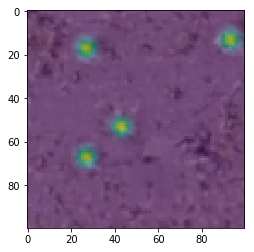

In [24]:
plt.figure()
plt.imshow(imagen)
plt.imshow(densidad, alpha=0.55)

In [38]:
unique, counts = np.unique(lista_etiquetas, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  1 213]
 [  2 419]
 [  3 683]
 [  4 909]
 [  5 913]
 [  6 989]
 [  7 850]
 [  8 480]
 [  9  96]
 [ 10  12]
 [ 11   1]]


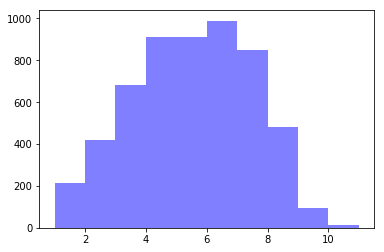

In [40]:
n, bins, patches = plt.hist(lista_etiquetas, unique, facecolor='blue', alpha=0.5)